In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd

from utils.train_evaluate import Trainer
from models.TextRNN_MeanMaxPool import TextRNN_MeanMaxPool
from data_ag_news.data_process.data_process_glove import DataProcess

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dp = DataProcess('../datasets/train.jsonl', '../datasets/test.jsonl', device, 128)
train_loader, test_loader = dp.get_dataLoader(141)
pre_vector = dp.get_pre_trained("../../extra/glove_vector/glove.6B.50d.txt")
print(pre_vector.shape)

torch.Size([95812, 50])


In [3]:
model = TextRNN_MeanMaxPool(num_class=4, vocab_size=pre_vector.shape[0], embedding_size=pre_vector.shape[1],
                            hidden_size=256, num_layers=2, dropout_ratio=0.2, bidirectional=True)
# 使用模型预训练词向量矩阵
model.embed.weight.data.copy_(pre_vector)
model.embed.weight.requires_grad = False  # 冻结网络层,使之不参与训练
model = model.to(device)

epochs = 20
lr = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [4]:
def compute_metrics_f1(predict_all, y_true):
    """f1 score评估函数"""
    predict = predict_all.argmax(-1)
    label = y_true
    acc = f1_score(label, predict, average='micro')
    return {"f1": acc}


t_and_v = Trainer(model=model, optimizer=optimizer, criterion=criterion, epochs=epochs)

metric_result = t_and_v.train(train_loader=train_loader, valid_loader=test_loader,
                              compute_metrics=compute_metrics_f1, verbose=100)
metric_result_df = pd.DataFrame(metric_result)
metric_result_df.index.name = 'epoch'
metric_result_df

Train Epoch: 0  [0    /120000 (0  %)]	Loss: 1.567200	f1: 0.208984
Train Epoch: 0  [51200/120000 (43 %)]	Loss: 0.428598	f1: 0.847656
Train Epoch: 0  [102400/120000 (85 %)]	Loss: 0.347073	f1: 0.878906
Train Epoch: 0  [120000/120000 (100%)]	Loss: 0.360682	f1: 0.854167
----------------------------------------------------------------------------------------------------
Train Epoch: 1  [0    /120000 (0  %)]	Loss: 0.438761	f1: 0.853516
Train Epoch: 1  [51200/120000 (43 %)]	Loss: 0.347434	f1: 0.888672
Train Epoch: 1  [102400/120000 (85 %)]	Loss: 0.379400	f1: 0.865234
Train Epoch: 1  [120000/120000 (100%)]	Loss: 0.292714	f1: 0.895833
----------------------------------------------------------------------------------------------------
Train Epoch: 2  [0    /120000 (0  %)]	Loss: 0.340687	f1: 0.884766
Train Epoch: 2  [51200/120000 (43 %)]	Loss: 0.354309	f1: 0.888672
Train Epoch: 2  [102400/120000 (85 %)]	Loss: 0.358875	f1: 0.876953
Train Epoch: 2  [120000/120000 (100%)]	Loss: 0.330695	f1: 0.869792


,Training loss,Training f1,Validation loss,Validation f1
epoch,,,,
0,0.383821,0.865200,0.390228,0.859605
1,0.332810,0.882175,0.340835,0.877632
2,0.315023,0.889725,0.321498,0.887237
3,0.329241,0.882675,0.336850,0.879342
4,0.307065,0.891725,0.316535,0.889737
5,0.299381,0.894517,0.310427,0.891316
6,0.328113,0.883433,0.337019,0.884211
7,0.301597,0.892033,0.309592,0.889211
8,0.278214,0.901117,0.288481,0.898421


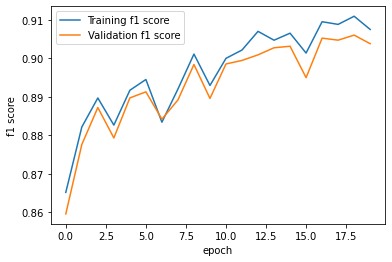

In [5]:
plt.plot(metric_result['Training f1'], label='Training f1 score')
plt.plot(metric_result['Validation f1'], label='Validation f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend()
plt.show()